<a href="https://colab.research.google.com/github/sayali27/Sentiment-Analysis/blob/master/Sequence_Modeling_Language_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/jannesklaas/frenchenglish-bilingual-pairs

#Importing required libraries

In [ ]:
#Importing library
import os, sys, time, random
import h5py
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import *
from keras.initializers import *
from keras.optimizers import Adam
import tensorflow as tf

#Specifying values for the hyperparameters

In [ ]:
#Hyperparameters
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

#Loading and preprocessing

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open('fra.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [ ]:
#Print size
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


#Defining data for encoder and decoder

In [ ]:
#Define data for encoder and decoder
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

#Definining the encoder-decoder model

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
#Model Summary
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None, 93)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 335872      input_7[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  358400      input_8[0][0]                    
                                                                 lstm_2[0][1]         

In [ ]:
#Model Shape
print("encoder_input_data shape:",encoder_input_data.shape)
print("decoder_input_data shape:",decoder_input_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

encoder_input_data shape: (10000, 16, 71)
decoder_input_data shape: (10000, 59, 93)
decoder_target_data shape: (10000, 59, 93)


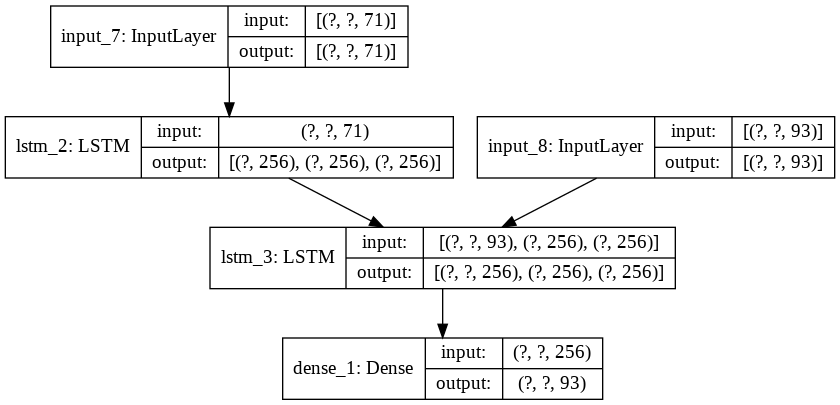

In [ ]:
#Visuaize the model
plot_model(model,show_shapes=True)

#Training the model

In [ ]:
# Compiling and training the model
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=50, validation_split=0.2)

Epoch 1/50
125/125 [==============================] - 5s 39ms/step - loss: 0.2079 - val_loss: 0.5665
Epoch 2/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1738 - val_loss: 0.5505
Epoch 3/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1607 - val_loss: 0.5469
Epoch 4/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1465 - val_loss: 0.5585
Epoch 5/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1393 - val_loss: 0.5558
Epoch 6/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1305 - val_loss: 0.5623
Epoch 7/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1247 - val_loss: 0.5735
Epoch 8/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1182 - val_loss: 0.5814
Epoch 9/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1142 - val_loss: 0.5875
Epoch 10/50
125/125 [==============================] - 4s 32ms/step - loss: 0.1110 - val_lo

#Defining the sample model using the parameters of the trained model

In [ ]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

#Defining the decode sequence for the text

In [ ]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

#Checking the model to decode the input sequence into the target sequence

In [ ]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Wow!
Decoded sentence: Travaillez len miennes.

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Saute.

-
Input sentence: Stop!
Decoded sentence: Arrête ça maintenant.

-
Input sentence: Stop!
Decoded sentence: Arrête ça maintenant.

-
Input sentence: Stop!
Decoded sentence: Arrête ça maintenant.

